In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from collections import Counter
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet


**Информация о датасете:**
Датасет был создан, чтобы выяснить, можно ли заменить дорогостояющую проверку сложных моделей процессов прогнозированием результатов аукциона.


---


Каждая строка датасета - один цикл проверки. Проверяем, возможна ли конкретная цена для конкретного товара, и может ли конкретный участник торгов выиграть товар по этой цене.

Фичи:


1.   process.b1.capacity - Вместимость (максимальное количество продуктов, которые нужно выиграть) Участника торгов 1.
2.   process.b2.capacity - Емкость (максимальное количество продуктов, которые нужно выиграть) Участника торгов 2.
3.  process.b3.capacity - Емкость (максимальное количество продуктов, которые нужно выиграть) Участника торгов 3.
4. process.b4.capacity - Вместимость (максимальное количество продуктов, которые нужно выиграть) Участника торгов 4.
5. property.price - Цена в данный момент подтверждена.
6. property.product - Продукт в настоящее время проверен.
7. property.winner - 	Участник торгов в настоящее время подтвержден как победитель продукта (0, если подтверждена только цена).
8. verification.result - Результат двоичной проверки - возможен ли проверенный результат?
9. verification.time - Время выполнения процедуры проверки.



**Для начала скачаем датасет и загрузим его в фрейм данных. Распечатаем первые 3 строки.**

In [ ]:
data = pd.read_csv("/content/data.csv")
data.head(3)

,process.b1.capacity,process.b2.capacity,process.b3.capacity,process.b4.capacity,property.price,property.product,property.winner,verification.result,verification.time
0,0,0,2,1,59,1,0,False,163.316667
1,0,0,2,1,59,2,0,False,200.860000
2,0,0,2,1,59,4,0,False,154.888889


Распечатаем кол-во строк и столбцов, названия колонок, статистическую информацию

In [ ]:
print(data.shape)
print(data.columns)
print(data.describe())

(2043, 9)
Index(['process.b1.capacity', 'process.b2.capacity', 'process.b3.capacity',
       'process.b4.capacity', 'property.price', 'property.product',
       'property.winner', 'verification.result', 'verification.time'],
      dtype='object')
       process.b1.capacity  process.b2.capacity  process.b3.capacity  \
count          2043.000000          2043.000000          2043.000000   
mean              1.000000             2.093979             1.883994   
std               0.816696             0.811269             0.320310   
min               0.000000             0.000000             1.000000   
25%               0.000000             1.000000             2.000000   
50%               1.000000             2.000000             2.000000   
75%               2.000000             3.000000             2.000000   
max               2.000000             3.000000             2.000000   

       process.b4.capacity  property.price  property.product  property.winner  \
count          2043.000

Посмотрим количество пропущенных значений

In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   process.b1.capacity  2043 non-null   int64  
 1   process.b2.capacity  2043 non-null   int64  
 2   process.b3.capacity  2043 non-null   int64  
 3   process.b4.capacity  2043 non-null   int64  
 4   property.price       2043 non-null   int64  
 5   property.product     2043 non-null   int64  
 6   property.winner      2043 non-null   int64  
 7   verification.result  2043 non-null   bool   
 8   verification.time    2043 non-null   float64
dtypes: bool(1), float64(1), int64(7)
memory usage: 129.8 KB
None


Удалим таргет из исходного датасета

In [ ]:
y = data.pop('verification.time')

In [ ]:
df = data

Разделим данные на обучающую и тестовую выборки в пропорциях 70/30

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=0.3, random_state=17, shuffle=True
)

Используем MinMaxScaler, так как с ним метрики становятся лучше во всех моделях, по сравнению с StandartScaler

In [ ]:
scaler = MinMaxScaler()
df_scaled_train = scaler.fit_transform(X_train)
df_scaled_test = scaler.fit_transform(X_test)

Функция для расчета нужных метрик

In [ ]:
def Reg_Models_Evaluation_Metrics (model,X_train,y_train,X_test,y_test,y_pred):
    cv_score = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10)

    # Calculating Adjusted R-squared
    r2 = model.score(X_test, y_test)
    # Number of observations is the shape along axis 0
    n = X_test.shape[0]
    # Number of features (predictors, p) is the shape along axis 1
    p = X_test.shape[1]
    # Adjusted R-squared formula
    adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    R2 = model.score(X_test, y_test)
    CV_R2 = cv_score.mean()

    print(f'RMSE:  {round(RMSE,4)}\n  R2: {round(R2,4)}\n Adjusted R2: {round(adjusted_r2, 4)}\n Cross Validated R2: {round(cv_score.mean(),4)}')
    return R2, adjusted_r2, CV_R2, RMSE

Линейная регрессия - инициализируем, обучаем, предсказываем на тесте, смотрим метрики

In [ ]:
modelLR = LinearRegression()
modelLR.fit(df_scaled_train, y_train)
y_pr_LR = modelLR.predict(df_scaled_test)
_ = Reg_Models_Evaluation_Metrics(modelLR, df_scaled_train, y_train, df_scaled_test, y_test, y_pr_LR)

RMSE:  8076.228
  R2: 0.3602
 Adjusted R2: 0.3517
 Cross Validated R2: 0.4055


Полиномиальная регрессия

In [ ]:
poly = PolynomialFeatures(degree=3, include_bias=False)
poly_features_train = poly.fit_transform(df_scaled_train)
poly_features_test = poly.fit_transform(df_scaled_test)

modelPR = LinearRegression()
modelPR.fit(poly_features_train, y_train)
y_pr_PR = modelPR.predict(poly_features_test)
_ = Reg_Models_Evaluation_Metrics(modelPR, poly_features_train, y_train, poly_features_test, y_test, y_pr_PR)

RMSE:  5542.0388
  R2: 0.6987
 Adjusted R2: 0.5884
 Cross Validated R2: 0.6974


Деревья принятия решений

In [ ]:
modelDT = DecisionTreeRegressor()
modelDT.fit(df_scaled_train, y_train)
y_dt_pred = modelDT.predict(df_scaled_test)
_ = Reg_Models_Evaluation_Metrics(modelDT, df_scaled_train, y_train, df_scaled_test, y_test, y_dt_pred)

RMSE:  1000.8725
  R2: 0.9902
 Adjusted R2: 0.99
 Cross Validated R2: 0.9907


Случайный лес

In [ ]:
modelRF = RandomForestRegressor(n_estimators=100)
modelRF.fit(df_scaled_train, y_train)
y_rf_pred = modelRF.predict(df_scaled_test)
_ = Reg_Models_Evaluation_Metrics(modelRF, df_scaled_train, y_train, df_scaled_test, y_test, y_rf_pred)

RMSE:  808.0524
  R2: 0.9936
 Adjusted R2: 0.9935
 Cross Validated R2: 0.9931


Метод опорных векторов

In [ ]:
modelSVR = SVR(kernel='poly')
modelSVR.fit(df_scaled_train, y_train)
y_svr_pred = modelSVR.predict(df_scaled_test)
_ = Reg_Models_Evaluation_Metrics(modelSVR, df_scaled_train, y_train, df_scaled_test, y_test, y_svr_pred)

RMSE:  11168.4345
  R2: -0.2235
 Adjusted R2: -0.2397
 Cross Validated R2: -0.2463


ElasticNet

In [ ]:
modelEN = ElasticNet(alpha=0.1, l1_ratio=0.8)
modelEN.fit(df_scaled_train, y_train)
y_en_pred = modelEN.predict(df_scaled_test)
_ = Reg_Models_Evaluation_Metrics(modelEN, df_scaled_train, y_train, df_scaled_test, y_test, y_en_pred)

RMSE:  8063.1077
  R2: 0.3623
 Adjusted R2: 0.3538
 Cross Validated R2: 0.4007


Градиентный бустинг

In [ ]:
modelGBR = GradientBoostingRegressor(random_state=0)
modelGBR.fit(df_scaled_train, y_train)
y_gbr_pred = modelGBR.predict(df_scaled_test)
_ = Reg_Models_Evaluation_Metrics(modelGBR, df_scaled_train, y_train, df_scaled_test, y_test, y_gbr_pred)

RMSE:  1651.6787
  R2: 0.9732
 Adjusted R2: 0.9729
 Cross Validated R2: 0.9742


Наилушее качество у моделей: случайный лес и градиентный бустинг.

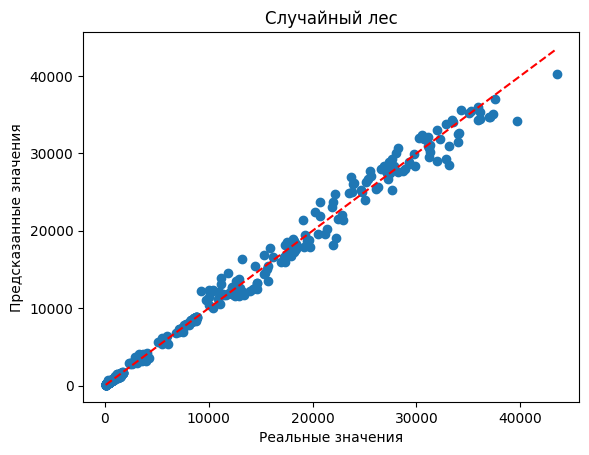

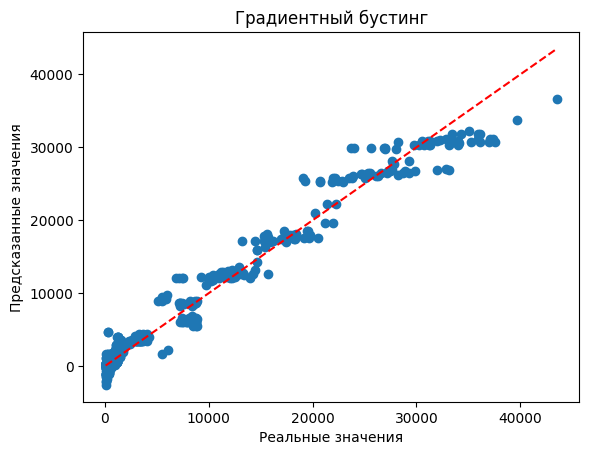

In [ ]:
plt.scatter(y_test, y_rf_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')
plt.title('Cлучайный лес')
plt.show()

plt.scatter(y_test, y_gbr_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')
plt.title('Градиентный бустинг')
plt.show()

Визуализируем зависимость между одним параметром и целевой переменной

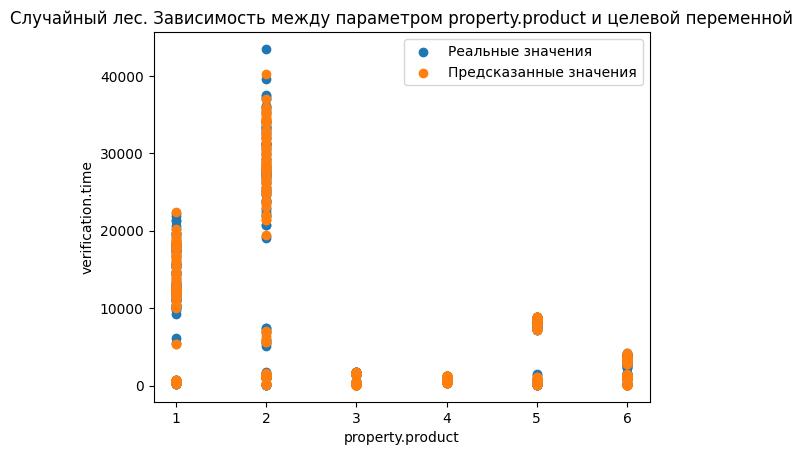

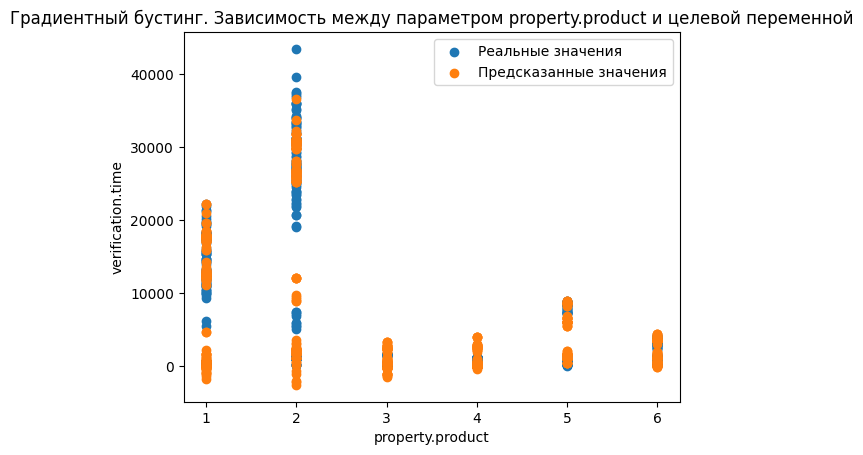

In [ ]:
plt.scatter(X_test['property.product'], y_test, label='Реальные значения')
plt.scatter(X_test['property.product'], y_rf_pred, label='Предсказанные значения')
plt.xlabel('property.product')
plt.ylabel('verification.time')
plt.title('Случайный лес. Зависимость между параметром property.product и целевой переменной')
plt.legend()
plt.show()

plt.scatter(X_test['property.product'], y_test, label='Реальные значения')
plt.scatter(X_test['property.product'], y_gbr_pred, label='Предсказанные значения')
plt.xlabel('property.product')
plt.ylabel('verification.time')
plt.title('Градиентный бустинг. Зависимость между параметром property.product и целевой переменной')
plt.legend()
plt.show()